<a href="https://colab.research.google.com/github/Monika171/Deep-Learning-with-Pytorch/blob/main/feedforward_dnn_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1djbwkMlmR0sFGPb95E3rUA2tdtFqGbBf')

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
import jovian

In [4]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

We can download the data and create a PyTorch dataset using the MNIST class from torchvision.datasets.

In [5]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Let's look at a couple of images from the dataset. The images are converted to PyTorch tensors with the shape 1x28x28 (the dimensions represent color channels, width and height). We can use plt.imshow to display the images. However, plt.imshow expects channels to be last dimension in an image tensor, so we use the permute method to reorder the dimensions of the image.



In [13]:
# image, label = dataset[0]
# print('image.shape:', image.shape)
# plt.imshow(image.permute(1, 2, 0), cmap='gray')
# print('Label:', label)

image.shape: torch.Size([1, 28, 28])
Label: 5


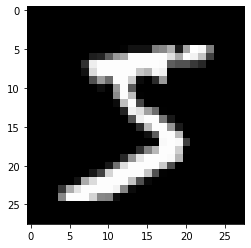

In [10]:
image, label = dataset[0]
print('image.shape:', image.shape)
# plt.imshow(image.permute(1,2,0), cmap='gray')
plt.imshow(image[0], cmap='gray')
print('Label:', label)

Next, let's use the random_split helper function to set aside 10000 images for our validation set.



In [14]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create PyTorch data loaders for training and validation.

In [15]:
batch_size = 128

In [16]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

Let's visualize a batch of data in a grid using the make_grid function from torchvision. We'll also use the .permute method on the tensor to move the channels to the last dimension, as expected by matplotlib.

images.shape: torch.Size([128, 1, 28, 28])


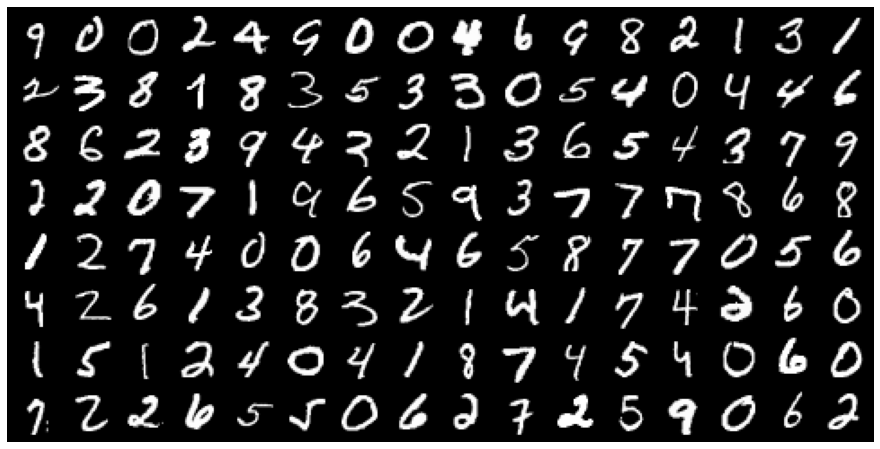

In [17]:
for images, _ in train_loader:
  print('images.shape:', images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
  break

##Hidden Layers, Activation Functions and Non-Linearity
We'll create a neural network with two layers: a hidden layer and an output layer. Additionally, we'll use an activation function between the two layers. Let's look at a step-by-step example to learn how hidden layers and activation functions can help capture non-linear relationships between inputs and outputs.

First, let's create a batch of inputs tensors. We'll flatten the 1x28x28 images into vectors of size 784, so they can be passed into an nn.Linear object.

In [18]:
for images, labels in train_loader:
  print('images.shape:', images.shape)
  inputs = images.reshape(-1, 784)
  print('inputs.shape:', inputs.shape)
  break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


Next, let's create a nn.Linear object, which will serve as our hidden layer. We'll set the size of the output from the hidden layer to 32. This number can be increased or decreased to change the learning capacity of the model.

In [19]:
input_size = inputs.shape[-1]
hidden_size = 32

In [20]:
layer1 = nn.Linear(input_size, hidden_size)

We can now compute intermediate outputs for the batch of images by passing inputs through layer1.

In [21]:
inputs.shape

torch.Size([128, 784])

In [23]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


The image vectors of size 784 are transformed into intermediate output vectors of length 32 by performing a matrix multiplication of inputs matrix with the transposed weights matrix of layer1 and adding the bias. We can verify this using torch.allclose

In [25]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [26]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Thus, layer1_outputs and inputs have a linear relationship, i.e., each element of layer_outputs is a weighted sum of elements from inputs. Thus, even as we train the model and modify the weights, layer1 can only capture linear relationships between inputs and outputs


Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula relu(x) = max(0,x) i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function

We can use the F.relu method to apply ReLU to the elements of a tensor.

In [27]:
F.relu(torch.tensor([[1, -1, 0], [-0.1, .2, .3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 0.3000]])

Let's apply the activation function to layer1_outputs and verify that negative values were replaced with 0.

In [28]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.9213658571243286
min(relu_outputs): 0.0


Now that we've applied a non-linear activation function, relu_outputs and inputs do not have a linear relationship. We refer to ReLU as the activation function, because for each input certain outputs are activated (those with non-zero values) while others turned off (those with zero values)

Next, let's create an output layer to convert vectors of length hidden_size in relu_outputs into vectors of length 10, which is the desired output of our model (since there are 10 target labels).

In [29]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [30]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [31]:
inputs.shape

torch.Size([128, 784])

In [32]:
jovian.commit(project='feedforward-dnn-gpu')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/monika171/feedforward-dnn-gpu


'https://jovian.ai/monika171/feedforward-dnn-gpu'